In [1]:
import math
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as st
from collections import Counter
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

### import  train,test, and label dataset

In [2]:
train = pd.read_csv("D:/Semester 7/Training_set_values.csv")
test = pd.read_csv("D:/Semester 7/Test_set_values.csv")
train_label = pd.read_csv("D:/Semester 7/Training_set_labels.csv")

In [3]:
train.head(10)
# train.columns

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
5,9944,20.0,2011-03-13,Mkinga Distric Coun,0,DWE,39.172796,-4.765587,Tajiri,0,...,per bucket,salty,salty,enough,enough,other,other,unknown,communal standpipe multiple,communal standpipe
6,19816,0.0,2012-10-01,Dwsp,0,DWSP,33.362410,-3.766365,Kwa Ngomho,0,...,never pay,soft,good,enough,enough,machine dbh,borehole,groundwater,hand pump,hand pump
7,54551,0.0,2012-10-09,Rwssp,0,DWE,32.620617,-4.226198,Tushirikiane,0,...,unknown,milky,milky,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump
8,53934,0.0,2012-11-03,Wateraid,0,Water Aid,32.711100,-5.146712,Kwa Ramadhan Musa,0,...,never pay,salty,salty,seasonal,seasonal,machine dbh,borehole,groundwater,hand pump,hand pump
9,46144,0.0,2011-08-03,Isingiro Ho,0,Artisan,30.626991,-1.257051,Kwapeto,0,...,never pay,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump


### plot bar chart for label set

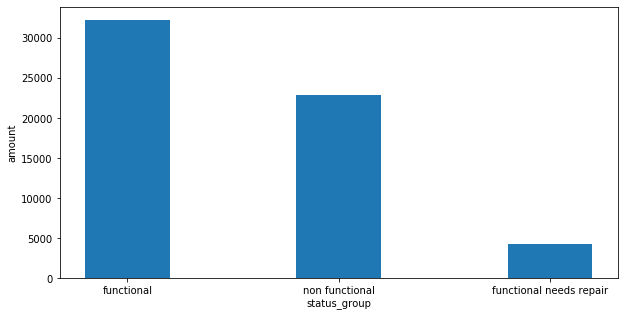

functional: 0.543080808080808
non functional: 0.3842424242424242
functional needs repair: 0.07267676767676767


In [4]:
status_group = train_label['status_group'].value_counts().to_dict()

type_ = list(status_group.keys())
values = list(status_group.values())
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(type_, values,
        width = 0.4)
 
plt.xlabel("status_group")
plt.ylabel("amount")
plt.show()

list_value = list(status_group.values())
list_value = [float(i)/sum(list_value) for i in list_value]
list_key = list(status_group.keys())
for i in range(len(list_value)):
    print(str(list_key[i])+": "+str(list_value[i]))

###### therefore dataset is imbalanced and we need to hadle this

### find duplicate rows


In [5]:
col_except_id = list(train.columns)[1:]

In [6]:
print("Number of duplicated rows in train set: " + str(train.duplicated(subset=col_except_id).sum()))

Number of duplicated rows in train set: 37


In [7]:
duplicate_indexes = train.loc[train.duplicated(subset=col_except_id), :]
duplicate_indexes = list(duplicate_indexes.index)
print(duplicate_indexes)

[7709, 8731, 11260, 13823, 17133, 22080, 22140, 25300, 25928, 28518, 29044, 31558, 34310, 34465, 35920, 36069, 37202, 37439, 37925, 38165, 39187, 40287, 40696, 42650, 44093, 46582, 46845, 46923, 49865, 53060, 53441, 53944, 56268, 56599, 57230, 58463, 58859]


### removing identical rows

In [8]:
print("Number of rows in train set: "+ str(len(train.index)))
print("Number of rows in test set: "+ str(len(test.index)))
print("Number of rows in train labels: "+ str(len(train_label.index)))

Number of rows in train set: 59400
Number of rows in test set: 14850
Number of rows in train labels: 59400


In [9]:
train = train.drop_duplicates(subset=col_except_id)
train_label = train_label.drop(train_label.index[duplicate_indexes])

In [10]:
print("Number of rows in train set after removing duplicates: "+ str(len(train.index)))
print("Number of rows in train label set after removing duplicates: "+ str(len(train_label.index)))

Number of rows in train set after removing duplicates: 59363
Number of rows in train label set after removing duplicates: 59363


### clarify whether identical rows are removed or not

In [11]:
print("Number of duplicated rows in train set: " + str(train.duplicated(subset=col_except_id).sum()))

Number of duplicated rows in train set: 0


### Find columns which contain NaN

In [12]:
train_col_with_NaN = train.columns[train.isna().any()].tolist()
test_col_with_NaN = test.columns[test.isna().any()].tolist()

print("columns which contain NaN in train set: " + str(train_col_with_NaN))
print("columns which contain NaN in test set: " + str(test_col_with_NaN))

columns which contain NaN in train set: ['funder', 'installer', 'subvillage', 'public_meeting', 'scheme_management', 'scheme_name', 'permit']
columns which contain NaN in test set: ['funder', 'installer', 'subvillage', 'public_meeting', 'scheme_management', 'scheme_name', 'permit']


### remove NaN values from identified columns using mode

In [13]:
for col in train_col_with_NaN:
    train[col].fillna(train[col].mode()[0], inplace = True)
    test[col].fillna(test[col].mode()[0], inplace=True)

### clarify whether NaN values are replced

In [14]:
train.columns[train.isna().any()].tolist()
test.columns[test.isna().any()].tolist()

[]

In [15]:
train.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


### Change values less than 25 in funder and installer column to 'others'

In [16]:
train.loc[:, 'funder'].value_counts(dropna=False)

Government Of Tanzania     12711
Danida                      3114
Hesawa                      2198
Rwssp                       1372
World Bank                  1349
                           ...  
Mazaro Kabula                  1
Dwe/ubalozi Wa Marekani        1
Ilo/undp                       1
Sindida Yetu                   1
Africaone Ltd                  1
Name: funder, Length: 1897, dtype: int64

In [17]:
train.loc[:, 'installer'].value_counts(dropna=False)

DWE                  21040
Government            1818
RWE                   1205
Commu                 1060
DANIDA                1050
                     ...  
VICF                     1
Danda                    1
Afroz Ismail             1
AQUA BLUES ANGELS        1
Africaone Ltd            1
Name: installer, Length: 2145, dtype: int64

In [18]:
counts_fun_train = train['funder'].value_counts().to_dict()
counts_ins_train = train['installer'].value_counts().to_dict()

for key in counts_fun_train:
    if (counts_fun_train[key]<=25):
        train["funder"].replace({key: "others"}, inplace=True)
        

        
for key in counts_ins_train:
    if (counts_ins_train[key]<=25):
        train['installer'].replace({key: "others"}, inplace=True)
        

counts_fun_test = test['funder'].value_counts().to_dict()
counts_ins_test = test['installer'].value_counts().to_dict()

for key in counts_fun_test:
    if (counts_fun_test[key]<=25):
        train["funder"].replace({key: "others"}, inplace=True)
        

        
for key in counts_ins_test:
    if (counts_ins_test[key]<=25):
        train['installer'].replace({key: "others"}, inplace=True)

### Exatract month and year from "date_recorded" column and create new columns called month and year

In [19]:
train['month']=pd.to_datetime(train.date_recorded).dt.month
test['month']=pd.to_datetime(test.date_recorded).dt.month

train['year']=pd.to_datetime(train.date_recorded).dt.year
test['year']=pd.to_datetime(test.date_recorded).dt.year

train = train.drop(['date_recorded'], axis = 1)
test = test.drop(['date_recorded'], axis = 1)
col_except_id.remove('date_recorded')



In [20]:
train.head()

,id,amount_tsh,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,...,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,month,year
0,69572,6000.0,Roman,1390,others,34.938093,-9.856322,none,0,Lake Nyasa,...,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,3,2011
1,8776,0.0,others,1399,others,34.698766,-2.147466,Zahanati,0,Lake Victoria,...,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,3,2013
2,34310,25.0,others,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,...,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,2,2013
3,67743,0.0,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,...,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,1,2013
4,19728,0.0,others,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,...,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,7,2011


In [21]:
test.head()

,id,amount_tsh,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,...,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,month,year
0,50785,0.0,Dmdd,1996,DMDD,35.290799,-4.059696,Dinamu Secondary School,0,Internal,...,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,other,other,2,2013
1,51630,0.0,Government Of Tanzania,1569,DWE,36.656709,-3.309214,Kimnyak,0,Pangani,...,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe,2,2013
2,17168,0.0,Government Of Tanzania,1567,DWE,34.767863,-5.004344,Puma Secondary,0,Internal,...,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,other,other,2,2013
3,45559,0.0,Finn Water,267,FINN WATER,38.058046,-9.418672,Kwa Mzee Pange,0,Ruvuma / Southern Coast,...,good,dry,dry,shallow well,shallow well,groundwater,other,other,1,2013
4,49871,500.0,Bruder,1260,BRUDER,35.006123,-10.950412,Kwa Mzee Turuka,0,Ruvuma / Southern Coast,...,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,3,2013


### perform log normalization for population column

In [22]:
train.population = train.population.apply(lambda x: np.log10(x+1))
test.population = test.population.apply(lambda x: np.log10(x+1))

### convert 0 value in installer column to "others"

In [23]:
ins = train['installer'].unique()
ins = list(ins)
ins.sort()
print(ins)


['0', 'ACRA', 'AMREF', 'Adra', 'Amref', 'Artisan', 'CEFA', 'CES', 'Centr', 'Central government', 'Central govt', 'Commu', 'Community', 'Consulting Engineer', 'DA', 'DANID', 'DANIDA', 'DDCA', 'DH', 'DMDD', 'DW', 'DWE', 'DWSP', 'Da', 'Distri', 'District Council', 'District council', 'Dmdd', 'FW', 'FinW', 'Fini Water', 'GOVER', 'Gove', 'Gover', 'Government', 'HE', 'HESAWA', 'Halmashauri ya wilaya sikonge', 'Handeni Trunk Main(', 'Hesawa', 'ISF', 'Idara ya maji', 'Ir', 'Is', 'JAICA', 'JICA', 'KKKT', 'KKKT _ Konde and DWE', 'Ki', 'Kiliwater', 'Kuwait', 'LGA', 'LWI', 'Lawatefuka water sup', 'MWE', 'Magadini-Makiwaru wa', 'Mission', 'NORAD', 'Norad', 'OXFAM', 'Private', 'RC', 'RC CHURCH', 'RWE', 'RWSSP', 'SEMA', 'SHIPO', 'Sengerema Water Department', 'TASAF', 'TCRS', 'TWE', 'TWESA', 'Tardo', 'UNICEF', 'VWC', 'Villagers', 'WEDECO', 'WU', 'WVT', 'Wizara ya maji', 'World', 'World Bank', 'World Vision', 'World vision', 'others', 'wananchi']


In [24]:
train.installer.replace(to_replace=(None,'0'), value = "others", inplace = True)

In [25]:
train['construction_year']=pd.to_numeric(train['construction_year'])
test['construction_year']=pd.to_numeric(test['construction_year'])

### convert 0 value in funder column to "others"

In [26]:
funder = train['funder'].unique()
funder = list(funder)
funder.sort()
funder

['0',
 'Adb',
 'Adra',
 'African',
 'Aict',
 'Amref',
 'Anglican Church',
 'Caritas',
 'Ces (gmbh)',
 'Ces(gmbh)',
 'Co',
 'Community',
 'Concern',
 'Concern World Wide',
 'Danida',
 'Ded',
 'Dh',
 'Dhv',
 'District Council',
 'Dmdd',
 'Dwe',
 'Dwsp',
 'Fin Water',
 'Fini Water',
 'Finw',
 'Fw',
 'Germany Republi',
 'Go',
 'Government Of Tanzania',
 'Halmashauri Ya Wilaya Sikonge',
 'He',
 'Hesawa',
 'Hifab',
 'Ir',
 'Isf',
 'Jaica',
 'Jica',
 'Ki',
 'Kiliwater',
 'Kkkt',
 'Kkkt_makwale',
 'Kuwait',
 'Lawatefuka Water Supply',
 'Lga',
 'Lvia',
 'Lwi',
 'Magadini-makiwaru Water',
 'Ministry Of Water',
 'Mission',
 'Mkinga Distric Coun',
 'Nethalan',
 'Netherlands',
 'No',
 'Norad',
 'Oikos E.Afrika',
 'Oxfam',
 'Oxfarm',
 'Plan Int',
 'Private',
 'Private Individual',
 'Rc',
 'Rc Church',
 'Roman',
 'Roman Catholic',
 'Rudep',
 'Rural Water Supply And Sanitat',
 'Rwssp',
 'Shipo',
 'Swedish',
 'Tanza',
 'Tardo',
 'Tasaf',
 'Tcrs',
 'Unhcr',
 'Unice',
 'Unicef',
 'Villagers',
 'W.B',
 'W

In [27]:
train.funder.replace(to_replace=(None, '0'), value = "others", inplace = True)

In [28]:
train.loc[:, 'scheme_management'].value_counts(dropna=False)

VWC                 40656
WUG                  5186
Water authority      3153
WUA                  2883
Water Board          2748
Parastatal           1677
Private operator     1063
Company              1061
Other                 766
SWC                    97
Trust                  72
None                    1
Name: scheme_management, dtype: int64

In [29]:
train.scheme_management.replace(to_replace=('None'), value = "others", inplace = True)

In [30]:
train.loc[:, 'scheme_management'].value_counts(dropna=False)

VWC                 40656
WUG                  5186
Water authority      3153
WUA                  2883
Water Board          2748
Parastatal           1677
Private operator     1063
Company              1061
Other                 766
SWC                    97
Trust                  72
others                  1
Name: scheme_management, dtype: int64

In [31]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14850 entries, 0 to 14849
Data columns (total 41 columns):
id                       14850 non-null int64
amount_tsh               14850 non-null float64
funder                   14850 non-null object
gps_height               14850 non-null int64
installer                14850 non-null object
longitude                14850 non-null float64
latitude                 14850 non-null float64
wpt_name                 14850 non-null object
num_private              14850 non-null int64
basin                    14850 non-null object
subvillage               14850 non-null object
region                   14850 non-null object
region_code              14850 non-null int64
district_code            14850 non-null int64
lga                      14850 non-null object
ward                     14850 non-null object
population               14850 non-null float64
public_meeting           14850 non-null bool
recorded_by              14850 non-null object
s

### calculate uncertainty coefficient to identify most realted feature

In [32]:
def entropy_data(x_data,y_data):
    
    entropy_of_data = 0
    count_xy = Counter(list(zip(x_data,y_data)))
    count_y = Counter(y_data)
    tot_occurr = sum(count_y.values())
    for ele in count_xy.keys():
        y_prob = count_y[ele[1]] / tot_occurr
        xy_prob = count_xy[ele] / tot_occurr
        entropy_of_data += xy_prob * math.log(y_prob/xy_prob)
    return entropy_of_data

def uncertainty_coefficient(x_data,y_data):
    count_x = Counter(x_data)
    total_occurr = sum(count_x.values())
    x_prob = list(map(lambda N: N/total_occurr, count_x.values()))
    x_ = st.entropy(x_prob)
    xy_ = entropy_data(x_data,y_data)
    if (x_ == 0):
        return 1
    else:
        out = (x_ - xy_) / x_
        return out

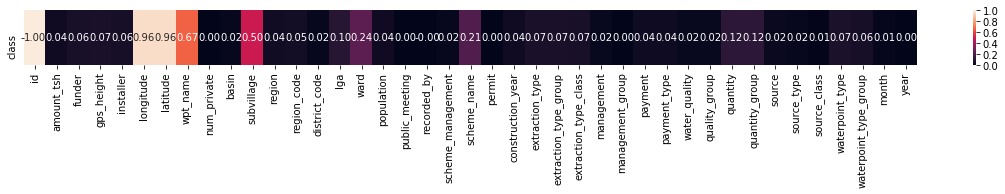

In [33]:
cols = train.columns
uncertainty_coe = pd.DataFrame(index=['class'],columns=train.columns)

for i in range(len(cols)):
    u = uncertainty_coefficient(train_label['status_group'].tolist(),train[cols[i]].tolist())
    uncertainty_coe.loc[:,cols[i]] = u
    
uncertainty_coe.fillna(value = np.nan,inplace = True)
plt.figure(figsize=(20,1))
sns.heatmap(uncertainty_coe, annot=True,fmt='.2f')
plt.show()

### remove less related columns from train and test sets

##### however removing following columns cause to reduce accuracy

In [34]:
# drop_columns = ['waterpoint_type_group','payment', 'region','extraction_type_class','management_group', 'quantity_group','recorded_by', 'source_type','extraction_type_group', 'source_class','quality_group', 'payment_type']
# test.drop(columns = drop_columns, inplace = True)
# train.drop(columns = drop_columns, inplace = True)

# for ele in drop_columns:
    
#     if (col in col_except_id):
#         col_except_id.remove(ele)


### Replace longitude=0,latitude=0 values with the mean of the respective region_code

In [35]:
train_g = train.groupby(['region_code'])[['latitude', 'longitude']].mean()

train.loc[train['longitude'] == 0,['latitude', 'longitude']] = train[train['longitude']==0].apply(lambda i: train_g.loc[i['region_code'],['latitude', 'longitude']],axis=1)[['latitude', 'longitude']]


test_g = test.groupby(['region_code'])[['latitude', 'longitude']].mean()

test.loc[test['longitude'] == 0,['latitude', 'longitude']] = test[test['longitude']==0].apply(lambda i: test_g.loc[i['region_code'],['latitude', 'longitude']],axis=1)[['latitude', 'longitude']]

### Label set encoding

In [36]:
data_classes = ['non functional', 'functional needs repair', 'functional']
encoded_label = dict(zip(data_classes, range(0,3,1)))
train_label['status_group'] = train_label['status_group'].map(encoded_label, na_action='ignore')


In [37]:
cat_features = []   #categorical feature list. used for LeaveOneOutEncoder and TargetEncoder
for ele in train.columns:
    if(type(train[ele][0]) is str):
        cat_features.append(ele)

### Do target encoding for non-numerical columns

#### copy train and test data to train_ and test_  for catboost training

In [38]:
from category_encoders import TargetEncoder
from category_encoders import LeaveOneOutEncoder

## create duplicate dataframe of train and test for catboost classification

train_ = train
test_ = test

train_encode = train_.sample(frac=0.25, random_state=42)
train_label_encode = train_label.loc[train_encode.index]

column_with_str = []
for col in col_except_id:
    if (type(train[col][0]) is str ):
        column_with_str.append(col)

enc = LeaveOneOutEncoder(cols=cat_features, sigma=0.05, random_state=42)
# enc = TargetEncoder(cols=cat_features)
    
enc = enc.fit(train_encode, train_label_encode['status_group'])
train_ = enc.transform(train_)
test_ = enc.transform(test_)

In [39]:
train_.head()

,id,amount_tsh,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,...,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,month,year
0,69572,6000.0,1.819444,1390,1.166904,34.938093,-9.856322,1.521277,0,1.380686,...,1.218915,1.383985,1.383985,1.340471,1.340471,1.155154,1.329718,1.245231,3,2011
1,8776,0.0,1.250143,1399,1.166904,34.698766,-2.147466,1.146919,0,1.086557,...,1.218915,1.148158,1.148158,1.334495,1.334495,1.195600,1.329718,1.245231,3,2013
2,34310,25.0,1.250143,686,1.467890,37.460664,-3.821329,1.163533,0,1.273863,...,1.218915,1.383985,1.383985,0.750000,0.750000,1.195600,0.857973,1.245231,2,2013
3,67743,0.0,1.200000,263,1.187500,38.486161,-11.155298,1.163533,0,0.820444,...,1.218915,0.059539,0.059539,1.052577,1.060822,1.155154,0.857973,1.245231,1,2013
4,19728,0.0,1.250143,0,1.285714,31.130847,-1.825359,1.092269,0,1.086557,...,1.218915,1.249487,1.249487,1.334495,1.334495,1.195600,1.329718,1.245231,7,2011


In [40]:
test_.head()

,id,amount_tsh,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,...,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,month,year
0,50785,0.0,1.705882,1996,1.650000,35.290799,-4.059696,1.163533,0,1.235535,...,1.218915,1.249487,1.249487,1.334495,1.334495,1.195600,0.325177,0.325177,2,2013
1,51630,0.0,0.993683,1569,1.193188,36.656709,-3.309214,1.163533,0,1.273863,...,1.218915,1.148158,1.148158,1.340471,1.340471,1.155154,1.329718,1.245231,2,2013
2,17168,0.0,0.993683,1567,1.193188,34.767863,-5.004344,1.163533,0,1.235535,...,1.218915,1.148158,1.148158,1.334495,1.334495,1.195600,0.325177,0.325177,2,2013
3,45559,0.0,1.163533,267,1.163533,38.058046,-9.418672,1.163533,0,0.820444,...,1.218915,0.059539,0.059539,1.038351,1.038351,1.155154,0.325177,0.325177,1,2013
4,49871,500.0,1.163533,1260,1.163533,35.006123,-10.950412,1.163533,0,0.820444,...,1.218915,1.383985,1.383985,1.340471,1.340471,1.155154,1.329718,1.245231,3,2013


### convert boolean value columns to 0's and 1's

In [41]:
train_.permit = train_.permit.astype(bool).astype(int)
train_.public_meeting = train_.public_meeting.astype(bool).astype(int)


train.permit = train.permit.astype(bool).astype(int)
train.public_meeting = train.public_meeting.astype(bool).astype(int)

test.permit = test.permit.astype(bool).astype(int)
test.public_meeting = test.public_meeting.astype(bool).astype(int)


test_.permit = test_.permit.astype(bool).astype(int)
test_.public_meeting = test_.public_meeting.astype(bool).astype(int)

### Perform onehot encoding for permit and public_meeting

In [42]:
train_ = pd.get_dummies(train_, columns = ['permit', 'public_meeting'])
train = pd.get_dummies(train, columns = ['permit', 'public_meeting'])

test = pd.get_dummies(test, columns = ['permit', 'public_meeting'])
test_ = pd.get_dummies(test_, columns = ['permit', 'public_meeting'])


In [43]:
train_.head()

,id,amount_tsh,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,...,source_type,source_class,waterpoint_type,waterpoint_type_group,month,year,permit_0,permit_1,public_meeting_0,public_meeting_1
0,69572,6000.0,1.819444,1390,1.166904,34.938093,-9.856322,1.521277,0,1.380686,...,1.340471,1.155154,1.329718,1.245231,3,2011,1,0,0,1
1,8776,0.0,1.250143,1399,1.166904,34.698766,-2.147466,1.146919,0,1.086557,...,1.334495,1.195600,1.329718,1.245231,3,2013,0,1,0,1
2,34310,25.0,1.250143,686,1.467890,37.460664,-3.821329,1.163533,0,1.273863,...,0.750000,1.195600,0.857973,1.245231,2,2013,0,1,0,1
3,67743,0.0,1.200000,263,1.187500,38.486161,-11.155298,1.163533,0,0.820444,...,1.060822,1.155154,0.857973,1.245231,1,2013,0,1,0,1
4,19728,0.0,1.250143,0,1.285714,31.130847,-1.825359,1.092269,0,1.086557,...,1.334495,1.195600,1.329718,1.245231,7,2011,0,1,0,1


### removing 'id' column from both train_ and train_label set

In [44]:
train_label = train_label.drop(['id'], axis=1)
train_ = train_.drop(['id'], axis=1)
train = train.drop(['id'], axis=1)

### split train data set to X_train and X_test 

In [45]:
X_train, X_test, y_train, y_test = train_test_split(train_,train_label['status_group'], test_size=0.1, stratify= train_label['status_group'])

### use SMOTE to handle imblanced train dataset

In [46]:
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SMOTENC

oversample = SMOTE(sampling_strategy = 'auto', n_jobs = -1, random_state=42)
X_sampled, y_sampled = oversample.fit_resample(train_, train_label)

In [47]:
oversample = SMOTE(sampling_strategy = 'auto', n_jobs = -1, random_state=42)
X_train_sampled, y_train_sampled = oversample.fit_resample(X_train, y_train)


### Normalization and classify using XGB classifier

In [48]:
model = XGBClassifier(objective = 'multi:softmax', booster = 'gbtree', nrounds = 'min.error.idx',
                      num_class = 3, maximize = False, eval_metric = 'merror', eta = .1,
                      max_depth = 16, colsample_bytree = .4, n_jobs = -1, random_state=42)


# X_sampled = ((X_sampled-X_sampled.min())/(X_sampled.max()-X_sampled.min()))
# X_train_sampled = ((X_train_sampled-X_train_sampled.min())/(X_train_sampled.max()-X_train_sampled.min()))
# X_train = ((X_train-X_train.min())/(X_train.max()-X_train.min()))
# X_test = ((X_test-X_test.min())/(X_test.max()-X_test.min()))

model.fit(X_sampled, y_sampled)

C:\Users\sh\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\sh\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[18:09:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "maximize", "nrounds" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.4, eta=0.1,
              eval_metric='merror', gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.100000001,
              max_delta_step=0, max_depth=16, maximize=False,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, nrounds='min.error.idx', num_class=3,
              num_parallel_tree=1, objective='multi:softprob', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', ...)

### Feature importance

[0.01217348 0.01748786 0.0110255  0.01255176 0.01432445 0.01146414
 0.01144216 0.01267455 0.02436103 0.02554546 0.02383915 0.01643518
 0.02041492 0.02328952 0.02314069 0.00962008 0.         0.0209794
 0.03716483 0.01413033 0.0264179  0.0395587  0.02998933 0.01799568
 0.01670549 0.02564694 0.01870577 0.01525803 0.01303936 0.06685212
 0.11671897 0.0235812  0.03737426 0.03600745 0.05064066 0.03592233
 0.01430212 0.01522856 0.01564509 0.01495326 0.01160372 0.01578865]


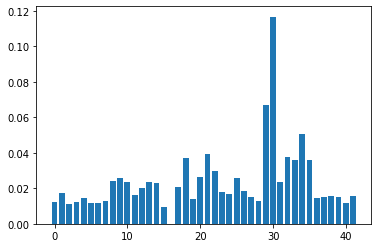

In [49]:
from matplotlib import pyplot
print(model.feature_importances_)

pyplot.bar(range(len(model.feature_importances_)), model.feature_importances_)
pyplot.show()

### predict outcome for  X_test, X_test, and X_train_sampled

In [50]:
X_train_sampled_predictions = model.predict(X_train_sampled)
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

### evaluate predictions

In [51]:
accuracy_sampled = accuracy_score(y_train_sampled, X_train_sampled_predictions)
print("Accuracy x_train_sampled: %.2f%%" % (accuracy_sampled * 100.0))

accuracy_train = accuracy_score(y_train, train_predictions)
print("Accuracy train: %.2f%%" % (accuracy_train * 100.0))

accuracy_test = accuracy_score(y_test, test_predictions)
print("Accuracy sample: %.2f%%" % (accuracy_test * 100.0))

Accuracy x_train_sampled: 96.36%
Accuracy train: 96.42%
Accuracy sample: 96.43%


### plot confusion matrices for XGB classifier

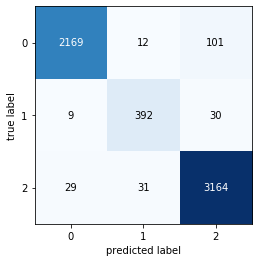

In [52]:
confusion_matrix = confusion_matrix(y_test, test_predictions)
plot_confusion_matrix(confusion_matrix)
plt.show()
# y_train.head()

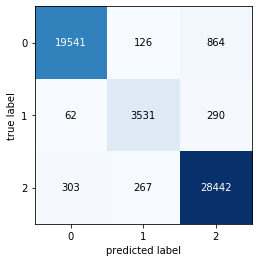

In [53]:
from sklearn.metrics import confusion_matrix
cfm = confusion_matrix(y_train, train_predictions)
plot_confusion_matrix(cfm)
plt.show()

# print(test_predictions)
# print(type(test_predictions))

### K-fold cross validation

In [54]:
cv = KFold(n_splits=10, random_state=42, shuffle=True)
scores = cross_val_score(model, X_train_sampled, y_train_sampled, scoring='accuracy', cv=5, n_jobs=-1)
print('Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

Accuracy: 0.866 (0.042)


In [55]:
t = test_['id']
test_ = test_.drop(["id"], axis = 1)

In [56]:
test_.head()

,amount_tsh,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,...,source_type,source_class,waterpoint_type,waterpoint_type_group,month,year,permit_0,permit_1,public_meeting_0,public_meeting_1
0,0.0,1.705882,1996,1.650000,35.290799,-4.059696,1.163533,0,1.235535,0.000000,...,1.334495,1.195600,0.325177,0.325177,2,2013,0,1,0,1
1,0.0,0.993683,1569,1.193188,36.656709,-3.309214,1.163533,0,1.273863,1.163533,...,1.340471,1.155154,1.329718,1.245231,2,2013,0,1,0,1
2,0.0,0.993683,1567,1.193188,34.767863,-5.004344,1.163533,0,1.235535,1.163533,...,1.334495,1.195600,0.325177,0.325177,2,2013,0,1,0,1
3,0.0,1.163533,267,1.163533,38.058046,-9.418672,1.163533,0,0.820444,1.163533,...,1.038351,1.155154,0.325177,0.325177,1,2013,0,1,0,1
4,500.0,1.163533,1260,1.163533,35.006123,-10.950412,1.163533,0,0.820444,1.163533,...,1.340471,1.155154,1.329718,1.245231,3,2013,0,1,0,1


### normalization of test_   set and predict values for  test_ dataset

In [57]:
# test_=((test_- test_.min())/(test_.max() - test_.min()))
test_predictions = model.predict(test_)

### create csv file for output predictions 

In [58]:
test_predictions = test_predictions.tolist()
list_to_csv = []
t = list(t)
for i  in range(len(t)):
    if (test_predictions[i] == 0):
        list_to_csv.append([t[i], 'non functional'])
    elif (test_predictions[i] == 1):
        list_to_csv.append([t[i], 'functional needs repair'])
    else:
        list_to_csv.append([t[i], 'functional'])

to_csv = pd.DataFrame(list_to_csv, columns=['id', 'status_group'])
to_csv.to_csv('submission.csv', index = False)

In [59]:
print(len(to_csv.index))

14850


### CatBoost classification

##### create list for holding categorical features

In [60]:
###   create list for holding categorical features

cat_features_ = []
for ele in train.columns:
    if(type(train[ele][0]) is str):
        cat_features_.append(ele)

In [61]:
cat_features_

['funder',
 'installer',
 'wpt_name',
 'basin',
 'subvillage',
 'region',
 'lga',
 'ward',
 'recorded_by',
 'scheme_management',
 'scheme_name',
 'extraction_type',
 'extraction_type_group',
 'extraction_type_class',
 'management',
 'management_group',
 'payment',
 'payment_type',
 'water_quality',
 'quality_group',
 'quantity',
 'quantity_group',
 'source',
 'source_type',
 'source_class',
 'waterpoint_type',
 'waterpoint_type_group']

In [62]:
train.columns

Index(['amount_tsh', 'funder', 'gps_height', 'installer', 'longitude',
       'latitude', 'wpt_name', 'num_private', 'basin', 'subvillage', 'region',
       'region_code', 'district_code', 'lga', 'ward', 'population',
       'recorded_by', 'scheme_management', 'scheme_name', 'construction_year',
       'extraction_type', 'extraction_type_group', 'extraction_type_class',
       'management', 'management_group', 'payment', 'payment_type',
       'water_quality', 'quality_group', 'quantity', 'quantity_group',
       'source', 'source_type', 'source_class', 'waterpoint_type',
       'waterpoint_type_group', 'month', 'year', 'permit_0', 'permit_1',
       'public_meeting_0', 'public_meeting_1'],
      dtype='object')

In [63]:
t_cat = test['id']
test = test.drop(["id"], axis = 1)

In [64]:
train[cat_features_] = train[cat_features_].astype('category')
test[cat_features_] = test[cat_features_].astype('category')

### split dataset into train and test sets

In [65]:
X_train_catboost, X_test_catboost, y_train_catboost, y_test_catboost = train_test_split(train,train_label['status_group'], test_size=0.1, stratify= train_label['status_group'])


### classify using catboost classifier

In [66]:
from catboost import CatBoostClassifier

clf = CatBoostClassifier(
    max_ctr_complexity=5,
    task_type = 'CPU',
    iterations=10000,
    eval_metric='AUC',
    od_type='Iter',
    od_wait=500,
    cat_features = cat_features,
    verbose=False
    
)


clf.fit(X_train_catboost,y_train_catboost, 
        cat_features=cat_features_, 
        eval_set=(X_test_catboost, y_test_catboost), 
        verbose=False
)

### predict outcome for train and test sets

In [67]:
test_pred = clf.predict(data=X_test_catboost)
train_pred = clf.predict(data=X_train_catboost)

### find accuracy for test and train sets

In [68]:
accuracy = accuracy_score(y_test_catboost, test_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 81.66%


In [69]:
accuracy = accuracy_score(y_train_catboost, train_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 88.90%


### Confusion matrix for Catboost

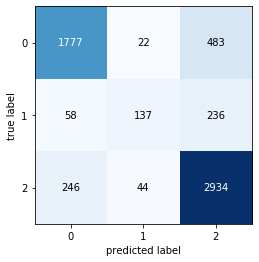

In [70]:
from sklearn.metrics import confusion_matrix
cfm = confusion_matrix(y_test_catboost, test_pred)
plot_confusion_matrix(cfm)
plt.show()

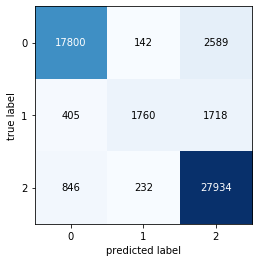

In [71]:
cfm = confusion_matrix(y_train_catboost, train_pred)
plot_confusion_matrix(cfm)
plt.show()

### K-Fold cross validation for Catboost

In [ ]:
cv = KFold(n_splits=10, random_state=42, shuffle=True)
scores = cross_val_score(clf, X_train_catboost, y_train_catboost, scoring='accuracy', cv=5, n_jobs=-1)
print('Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

### predict for test set

In [72]:
testpredictions = clf.predict(test)

### create csv file

In [73]:
test_predictions = testpredictions.tolist()
list_to_csv = []
t_catboost = list(t)
for i  in range(len(t)):
    if (test_predictions[i][0] == 0):
        list_to_csv.append([t_catboost[i], 'non functional'])
    elif (test_predictions[i][0] == 1):
        list_to_csv.append([t_catboost[i], 'functional needs repair'])
    elif (test_predictions[i][0] == 2):
        list_to_csv.append([t_catboost[i], 'functional'])

to_csv_ = pd.DataFrame(list_to_csv, columns=['id', 'status_group'])
to_csv_.to_csv('submission_catboost.csv', index = False)

### Catboost give high rank after submitting the csv file to drivendata